In [6]:
import pandas as pd
import numpy as np

In [7]:
def load_data(file_index):
    df=pd.read_csv(f'./scratch/{file_index}.csv')
    A=np.array(df,dtype=complex)
    return A

In [8]:
def compute_correlation_coefficients(z: np.ndarray,smoothed:bool=False) -> np.ndarray:
        """Compute correlation coefficients r = [r_0, r_1, ..., r_{n-1}]"""
        n = len(z)
        r = np.zeros(n, dtype=complex)
        
        for i in range(n):
            if i == 0:
                r[i] = np.mean(z * np.conj(z))
            else:
                sum_val = 0
                for j in range(0, n - i):
                    sum_val += z[j] * np.conj(z[j + i])
                r[i] = sum_val / n
                if smoothed:
                    r[i]=r[i]*np.sinc(i*n**(-0.2)/2)
        return r

In [9]:
def build_toeplitz_matrix(r: np.ndarray) -> np.ndarray:
        """
        Build Toeplitz HPD matrix from correlation coefficients as in Eq. (3)
        """
        n = len(r)
        R = np.zeros((n, n), dtype=complex)
        
        for i in range(n):
            for j in range(n):
                if i == j:
                    R[i, j] = r[0]
                elif i < j:
                    R[i, j] = np.conj(r[j - i])
                else:
                    R[i, j] = r[i - j]    
        return R

In [10]:
import scipy.linalg as la
def riemannian_distance(R1: np.ndarray, R2: np.ndarray) -> float:
        """
        Riemannian Distance (RD) as in Eq. (10): ‖log(R1⁻¹ R2)‖_F
        """
        try:
            R1_inv = np.linalg.inv(R1)
            M = R1_inv @ R2
            log_M = la.logm(M)
            # eival,eivect=np.linalg.eigh(log_M)
            # #print(eival)
            return np.linalg.norm(log_M, 'fro')
        except (np.linalg.LinAlgError, la.LinAlgError):
            print("ERROR!")
            return np.linalg.norm(R1 - R2, 'fro')

In [11]:
a=[1+0j,2+0j,1+0j,1+1j]
r=compute_correlation_coefficients(np.array(a),smoothed=False)
R=build_toeplitz_matrix(r)
print(R)

[[2.  +0.j   1.25+0.25j 0.75+0.5j  0.25+0.25j]
 [1.25-0.25j 2.  +0.j   1.25+0.25j 0.75+0.5j ]
 [0.75-0.5j  1.25-0.25j 2.  +0.j   1.25+0.25j]
 [0.25-0.25j 0.75-0.5j  1.25-0.25j 2.  +0.j  ]]


In [12]:
b=[1+0j,0.5+0j,0.2+0j,0.1+0.1j]
r2=compute_correlation_coefficients(np.array(b),smoothed=False)
R2=build_toeplitz_matrix(r2)
print(R2)

[[0.3275+2.08166817e-19j 0.155 +5.00000000e-03j 0.0625+1.25000000e-02j
  0.025 +2.50000000e-02j]
 [0.155 -5.00000000e-03j 0.3275+2.08166817e-19j 0.155 +5.00000000e-03j
  0.0625+1.25000000e-02j]
 [0.0625-1.25000000e-02j 0.155 -5.00000000e-03j 0.3275+2.08166817e-19j
  0.155 +5.00000000e-03j]
 [0.025 -2.50000000e-02j 0.0625-1.25000000e-02j 0.155 -5.00000000e-03j
  0.3275+2.08166817e-19j]]


In [13]:
print("Riemannian distance between R and R2:",riemannian_distance(R,R2))

Riemannian distance between R and R2: 3.271466992091135


In [14]:
def KLD_mean(list_of_matrices):
        """
        Compute the KLD mean of a list of HPD matrices as in Eq. (14)
        """
        n = len(list_of_matrices)
        mean_matrix = list_of_matrices[0]
        
        for _ in range(100):  # Maximum 100 iterations
            sum_term = np.zeros_like(mean_matrix)
            for R in list_of_matrices:
                R_inv = np.linalg.inv(R)
                mean_inv = np.linalg.inv(mean_matrix)
                # term = la.logm(mean_inv @ R)
                # sum_term += R @ term
                sum_term+=mean_inv
            sum_term /= n
            # mean_matrix = mean_matrix @ la.expm(mean_inv @ sum_term)
            mean_matrix = la.inv(sum_term)
        return mean_matrix

In [29]:
def from_data(A,num_pulses=7):
    list_of_matrices=[]
    for i in range(A.shape[1]):
        for j in range(0,A.shape[0]-num_pulses,num_pulses):
            z=A[j:j+num_pulses,i]
            r=compute_correlation_coefficients(z,smoothed=False)
            R=build_toeplitz_matrix(r)
            list_of_matrices.append(R)
    R_mean=KLD_mean(list_of_matrices)
    return R_mean,list_of_matrices

In [30]:
A=load_data(17)
R_mean,lm=from_data(A)

In [31]:
distances=[riemannian_distance(r,R_mean) for r in lm]

In [32]:
d=np.array(distances)

In [34]:
d=np.reshape(d,(14,-1))

In [35]:
m=np.mean(d,axis=1)
print(m)

[4.46671837 4.45629007 4.47903521 4.4360908  4.44031213 4.39953678
 4.36917229 5.91911433 6.80399782 6.45328297 5.20261343 4.43916403
 4.42373055 4.37630029]


In [36]:
def pipeline(file_index):
    A=load_data(file_index)
    R_mean,lm=from_data(A)
    distances=[riemannian_distance(r,R_mean) for r in lm]
    d=np.array(distances)
    d=np.reshape(d,(14,-1))
    m=np.mean(d,axis=1)
    return m

In [38]:
m=pipeline(30)
print(m)

[6.71318391 6.30892433 6.05463285 6.83720389 6.3495521  5.8339593
 5.69723486 5.90303015 6.66246738 5.98266678 5.75116283 5.93596468
 6.23192751 6.81628689]


In [39]:
m=pipeline(31)
print(m)

[11.3905641  11.35008888 11.51808931 12.06541467 11.96432855 10.10768345
  9.96272821 10.74168547 11.14296902 11.55803926 11.58378968 11.65309888
 11.55761474 12.03456872]


In [44]:
def optimized_projection_matrix(R_s: np.ndarray,k=2):
    d = R_s.shape[0]
    k = min(k, d)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(R_s)
    
    # Get indices sorted by eigenvalue (descending)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    
    # Take top-k eigenvalues and eigenvectors
    top_k_indices = sorted_indices[:k]
    
    eigenvalues_top_k = eigenvalues[top_k_indices].real
    eigenvectors_top_k = eigenvectors[:, top_k_indices].real
    
    # According to extended theorem: W* = [η_max1, η_max2, ..., η_maxk]
    W_star = eigenvectors_top_k
    
    # Orthogonalize (optional but recommended)
    W_star, _ = np.linalg.qr(W_star)
    
    return W_star, eigenvalues_top_k, eigenvectors_top_k

In [45]:
def from_data_with_projection(A,num_pulses=7):
    list_of_matrices=[]
    for i in range(A.shape[1]):
        for j in range(0,A.shape[0]-num_pulses,num_pulses):
            z=A[j:j+num_pulses,i]
            r=compute_correlation_coefficients(z,smoothed=False)
            R=build_toeplitz_matrix(r)
            W_star, eigenvalues_top_k, eigenvectors_top_k = optimized_projection_matrix(R,k=2)
            R= W_star.conj().T @ R @ W_star
            list_of_matrices.append(R)
    R_mean=KLD_mean(list_of_matrices)
    return R_mean,list_of_matrices

In [46]:
def pipeline_with_projection(file_index):
    A=load_data(file_index)
    R_mean,lm=from_data_with_projection(A)
    distances=[riemannian_distance(r,R_mean) for r in lm]
    d=np.array(distances)
    d=np.reshape(d,(14,-1))
    m=np.mean(d,axis=1)
    return m

In [49]:
m=pipeline_with_projection(31)
print(m)

[6.51765957 6.49908348 6.57112939 6.84056319 6.74639637 5.5818687
 5.49756069 6.00046837 6.35061558 6.6005223  6.58876185 6.64596228
 6.61639046 6.90122205]


In [75]:
def generate_rd_map(data, num_pulses=7):
    """
    Generate Range-Doppler map from radar/sonar data.
    
    Parameters:
    -----------
    data : np.ndarray
        Input data of shape (num_range_bins, total_pulses)
        Example: (14, N) where N is total number of pulses
    num_pulses : int
        Number of coherent pulses to process together (default: 7)
    apply_window : bool
        Whether to apply windowing for Doppler processing
    
    Returns:
    --------
    rd_map : np.ndarray
        Range-Doppler map of shape (num_range_bins, num_pulses)
    """
    total_pulses,num_range_bins = data.shape
    
    # Step 1: Organize data into coherent batches
    num_batches = total_pulses // num_pulses
    data_batches = np.zeros((num_batches, num_pulses, num_range_bins),dtype=complex)
    
    for i in range(num_batches):
        start_idx = i * num_pulses
        end_idx = start_idx + num_pulses
        data_batches[i] = data[start_idx:end_idx,:]  # Shape: (num_pulses, num_range_bins)
    
    # Step 3: Doppler FFT for each range bin
    rd_maps = []
    for batch in data_batches:
        # batch shape: (num_pulses, num_range_bins)
        # Perform FFT along pulse dimension (Doppler dimension)
        doppler_fft = np.fft.fftshift(np.fft.fft(batch, axis=0), axes=0)
        rd_maps.append(np.abs(doppler_fft))
    
    # Step 4: Average across batches
    rd_map = np.mean(rd_maps, axis=0)
    
    return rd_map  # Return as (range_bins, doppler_bins)

In [76]:
A=load_data(31)
rd_map=generate_rd_map(A,num_pulses=7)
print(rd_map.shape)

(7, 14)


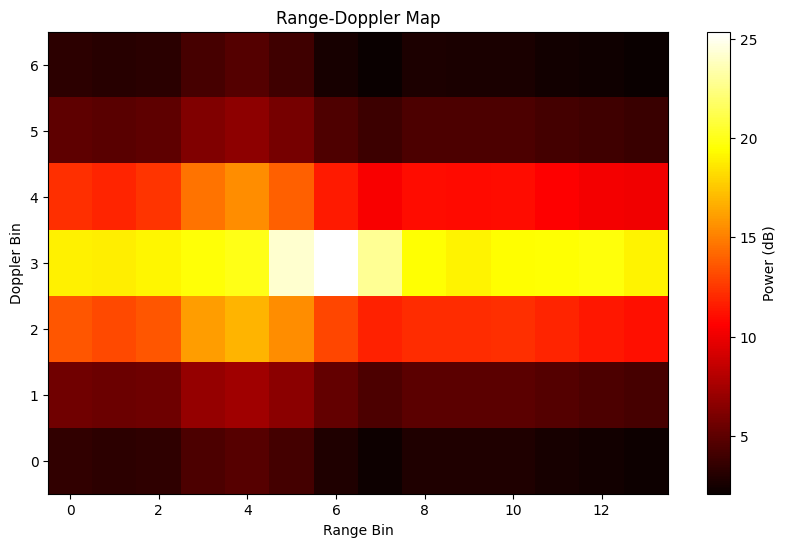

In [79]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.imshow(20 * np.log10(rd_map + 1e-10), 
            aspect='auto', 
            cmap='hot',
            origin='lower')
plt.colorbar(label='Power (dB)')
plt.ylabel('Doppler Bin')
plt.xlabel('Range Bin')
plt.title('Range-Doppler Map')
plt.show()